<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

# Using the Python 'requests' library to interface with APIs

Many websites use APIs (Application Programming Interface) to provide data and other services that a web application accesses. The so called "REST" API is the standard, and is uses two methods relevant for web scraping:

* GET – Retrieve data
* POST – Create data (e.g. asking the web service to search / filter data)

Many websites require additional metadata to be passed along with the HTTP request, and these are typically placed in the header, and may include things like authentication token, cookies, content format to be returned, etc.

For 'POST' requests, you may also need to pass along a payload, containing inputs to e.g. search / filter operations. 

**Two common ways of using HTTP requests**
* If the website has a well-documented API service, the documentation will tell you how to submit the requests
* When navigating a website in the browser, you can use Developer Tools (Network panel) to see what requests are being made, and then imitate them on your browser 

**Table of Contents**
<h1>Table of Contents<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#Using-the-Python-'requests'-library-to-interface-with-APIs" data-toc-modified-id="Using-the-Python-'requests'-library-to-interface-with-APIs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using the Python 'requests' library to interface with APIs</a></span></li><li><span><a href="#Using-known-APIs" data-toc-modified-id="Using-known-APIs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using known APIs</a></span><ul class="toc-item"><li><span><a href="#Example:-Fetching-data-from-SEC's-EDGAR-database-of-company-filings" data-toc-modified-id="Example:-Fetching-data-from-SEC's-EDGAR-database-of-company-filings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example: Fetching data from SEC's EDGAR database of company filings</a></span></li><li><span><a href="#More-examples-to-be-added-based-on-project-work" data-toc-modified-id="More-examples-to-be-added-based-on-project-work-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>More examples to be added based on project work</a></span></li></ul></li><li><span><a href="#Manually-identifying-the-relevant-requests" data-toc-modified-id="Manually-identifying-the-relevant-requests-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Manually identifying the relevant requests</a></span></li></ul>

**We start with loading some libraries that are helpful with APIs**

In [2]:
import pandas as pd
import json
import requests
import pip_system_certs   # This is to avoid SSL errors when making requests to some webpages. The alternative is to use the argument 'verify = False' though that is risky for untrusted sites.

# Using known APIs

APIs from services such as Google, AWS, etc. require you have an account with an authentication token to use the API (to prevent users from abusing the service. 

Popular APIs also have Python wrappers (often unaffiliated libraries built by enthusiasts) so you don't need to craft your own requests. It may be worth searching for those before you embark on building your own.

## Example: Fetching data from SEC's EDGAR database of company filings

The EDGAR database has an easy to use API to fetch tables of data in json format. 

Documentation is here: https://www.sec.gov/edgar/sec-api-documentation, and a useful guide here: https://fishtail.ai/blog-2-accessing-company-financials-using-the-sec-edgar-api

Note, not all tables in the filings are available through their API, so you may need alternative methods to fetch the data (see the HTML scraping notebook)

We use ```headers={'User-Agent': 'Mozilla/5.0'}``` as an argument to avoid getting an error

**We start by manually finding the Central Index Key (CIK) for the entity**

You can either find the CIK manually, or use a company ticker (if publicly traded) to CIK

In [35]:
tickers = requests.get("https://www.sec.gov/files/company_tickers.json", headers={'User-Agent': 'Mozilla/5.0'})
ticker_mapping = pd.json_normalize(pd.json_normalize(tickers.json(),max_level=0).values[0])

In [37]:
# For Morgan Stanley
ticker_mapping[ticker_mapping['ticker']=='MS']

,cik_str,ticker,title
67,895421,MS,MORGAN STANLEY


**CIK strings need to have 10 characters, so pad it with 0s**

Then we fetch information of what kind of data is available for the company

In [43]:
CIK = "0000895421"
data_URL = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{CIK}.json"
data_request = requests.get(available_facts_URL, headers={'User-Agent': 'Mozilla/5.0'})

**This retrieves a json file with information about available data**

In [49]:
data_full = available_facts.json()
data_full['facts']['us-gaap'].keys()

dict_keys(['AccountsPayable', 'AccountsPayableCurrentAndNoncurrent', 'AccountsReceivableNet', 'AccruedFeesAndOtherRevenueReceivable', 'AccruedLiabilitiesAndOtherLiabilities', 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment', 'AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AdditionalPaidInCapital', 'AdjustmentsToAdditionalPaidInCapitalReallocationOfMinorityInterest', 'AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation', 'AllocatedShareBasedCompensationExpense', 'AllowanceForCreditLossesChangeInMethodOfCalculatingImpairment', 'AllowanceForLoanAndLeaseLossesAdjustment

**As seen above, there is a large number of quantities available**

Here, we extract "NetIncomeLoss"

In [55]:
key = 'NetIncomeLoss'
NetIncomeLoss_USD = pd.json_normalize(data_full['facts']['us-gaap']['NetIncomeLoss']['units']['USD'])
NetIncomeLoss_USD.head()

,start,end,val,accn,fy,fp,form,filed,frame
0,2006-12-01,2007-11-30,3209000000,0001193125-10-042763,2009,FY,10-K,2010-02-26,CY2007
1,2008-01-01,2008-06-30,2556000000,0001193125-09-169269,2009,Q2,10-Q,2009-08-07,NaN
2,2008-04-01,2008-06-30,1143000000,0001193125-09-169269,2009,Q2,10-Q,2009-08-07,CY2008Q2
3,2008-01-01,2008-09-30,10707000000,0001193125-09-227984,2009,Q3,10-Q,2009-11-09,NaN
4,2008-07-01,2008-09-30,8151000000,0001193125-09-227984,2009,Q3,10-Q,2009-11-09,CY2008Q3


**This includes different versions of similar information**

Here, we want quarterly data, so 'frame' needs to contain Q3

In [58]:
relevant_NetIncomeLoss_USD = NetIncomeLoss_USD[NetIncomeLoss_USD['frame'].astype('str').str.contains("Q")]
relevant_NetIncomeLoss_USD

,start,end,val,accn,fy,fp,form,filed,frame
2,2008-04-01,2008-06-30,1143000000,0001193125-09-169269,2009,Q2,10-Q,2009-08-07,CY2008Q2
4,2008-07-01,2008-09-30,8151000000,0001193125-09-227984,2009,Q3,10-Q,2009-11-09,CY2008Q3
10,2009-01-01,2009-03-31,-177000000,0001193125-11-050049,2010,FY,10-K,2011-02-28,CY2009Q1
15,2009-04-01,2009-06-30,149000000,0001193125-11-050049,2010,FY,10-K,2011-02-28,CY2009Q2
20,2009-07-01,2009-09-30,757000000,0001193125-11-050049,2010,FY,10-K,2011-02-28,CY2009Q3
24,2009-10-01,2009-12-31,617000000,0001193125-11-050049,2010,FY,10-K,2011-02-28,CY2009Q4
28,2010-01-01,2010-03-31,1776000000,0001193125-12-081807,2011,FY,10-K,2012-02-27,CY2010Q1
31,2010-03-31,2010-06-30,1960000000,0001193125-11-213320,2011,Q2,10-Q,2011-08-08,CY2010Q2
40,2010-07-01,2010-09-30,131000000,0001193125-12-081807,2011,FY,10-K,2012-02-27,CY2010Q3
45,2010-10-01,2010-12-31,836000000,0001193125-12-081807,2011,FY,10-K,2012-02-27,CY2010Q4


**A more advanced API was created by a third party here: https://sec-api.io/** 

## More examples to be added based on project work

# Manually identifying the relevant requests

Imagine you want to use a website's search functionality a large number of times, for example finding all investment advisors at JPM Wealth Management (https://wealthpartners.jpmorgan.com/search), where it is not practical to manually run each search. 

Most websites use APIs to search for results within a database, and when you using the website manually to submit a search request, the website fires of the HTTP request. 

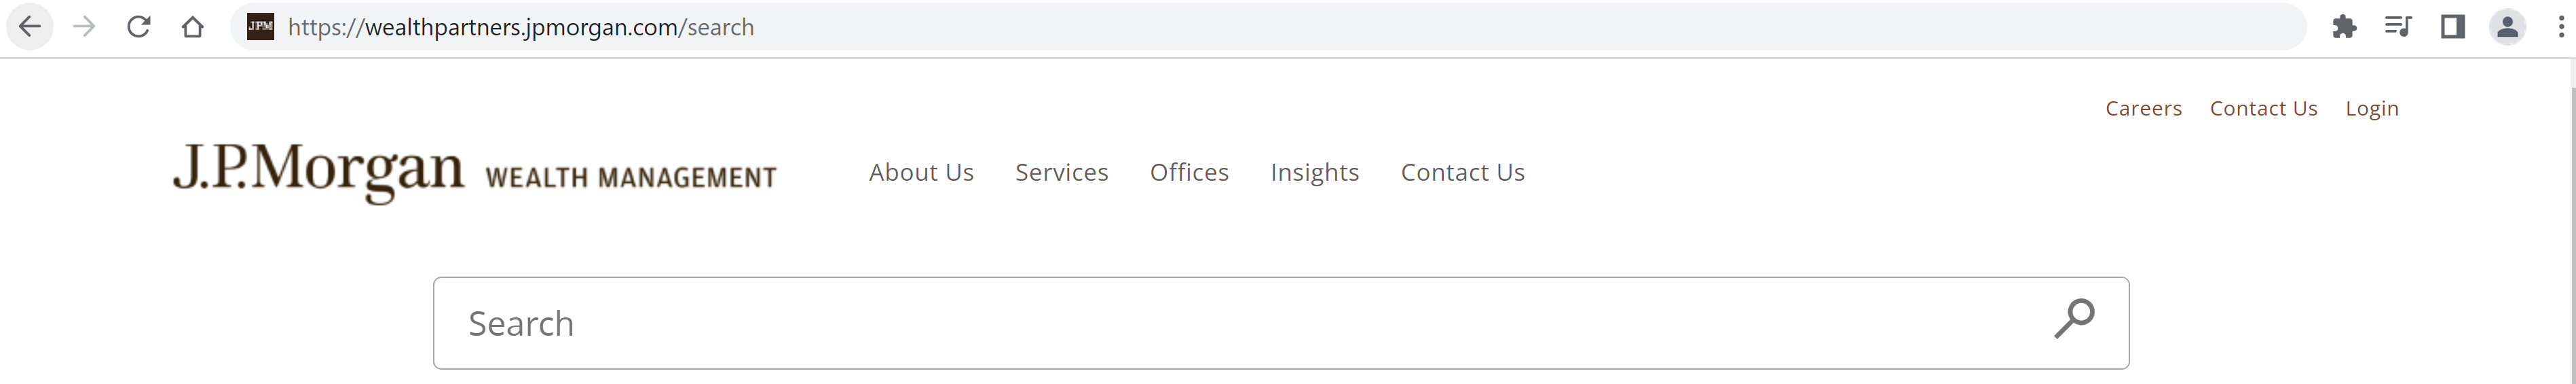

**In this example, we can search by zip code** (and we have a list of zip codes to use)

**Step 1: Open Developer Tools. On Chrome it is CTRL+SHIFT+I, and on Edge it is F12, and click on the 'Network' tab**

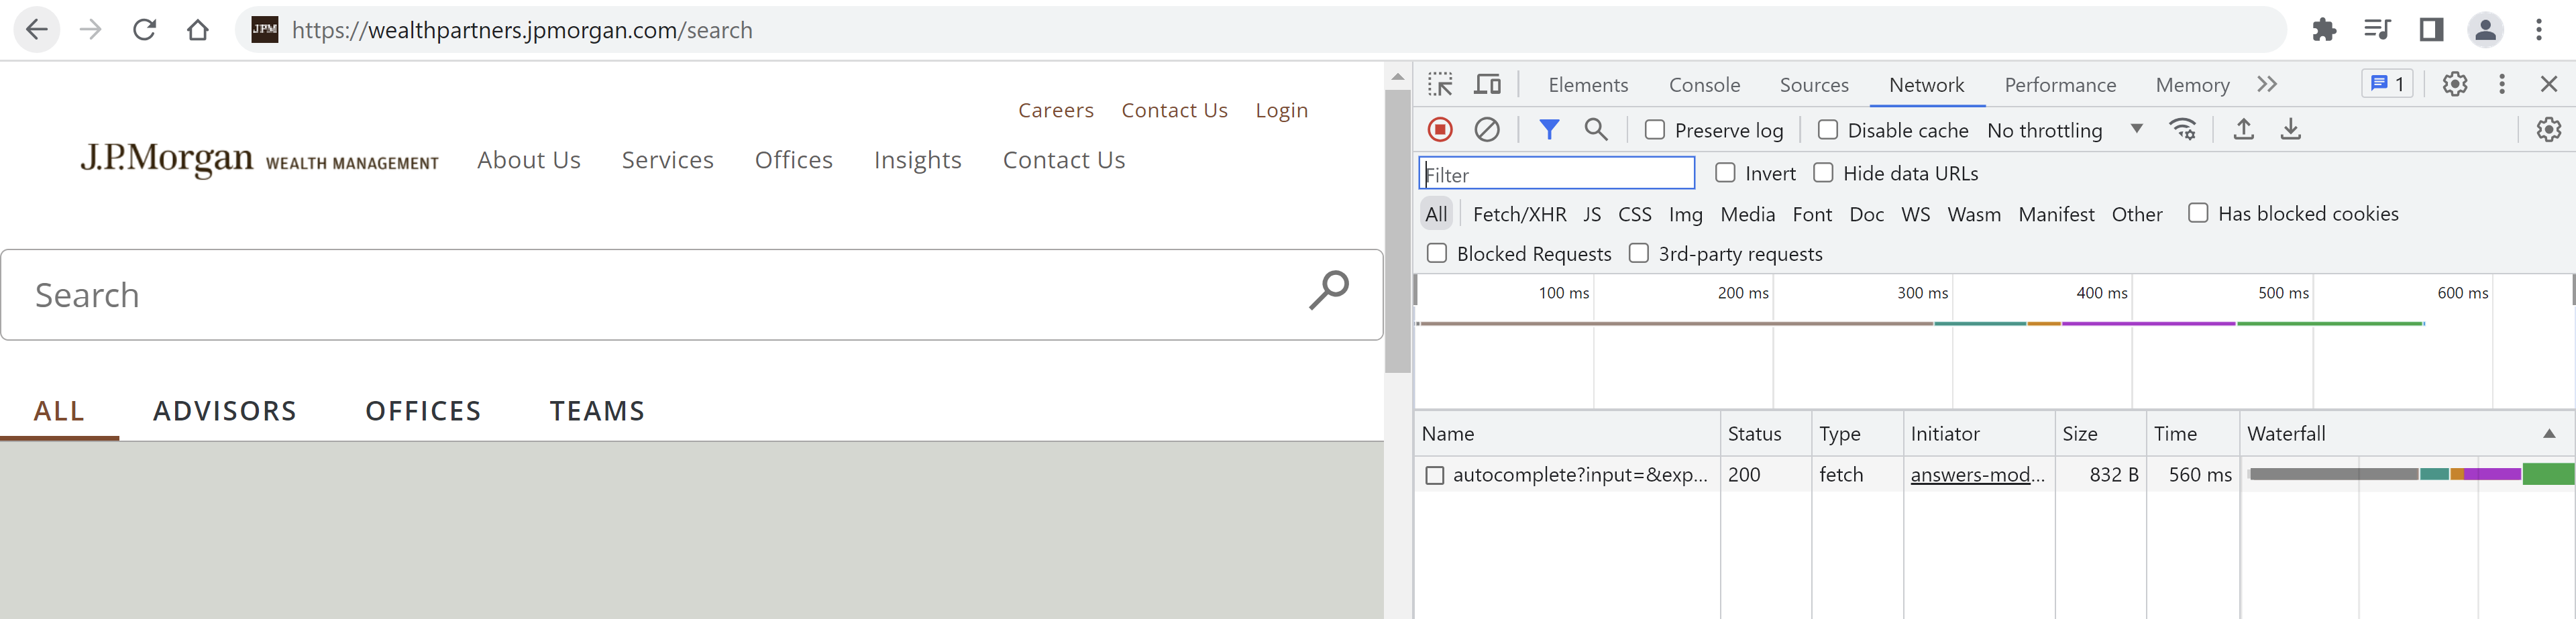

**Step 2: Enter your search term, and click on search. You will notice that the Network tab starts filling up with traffic**

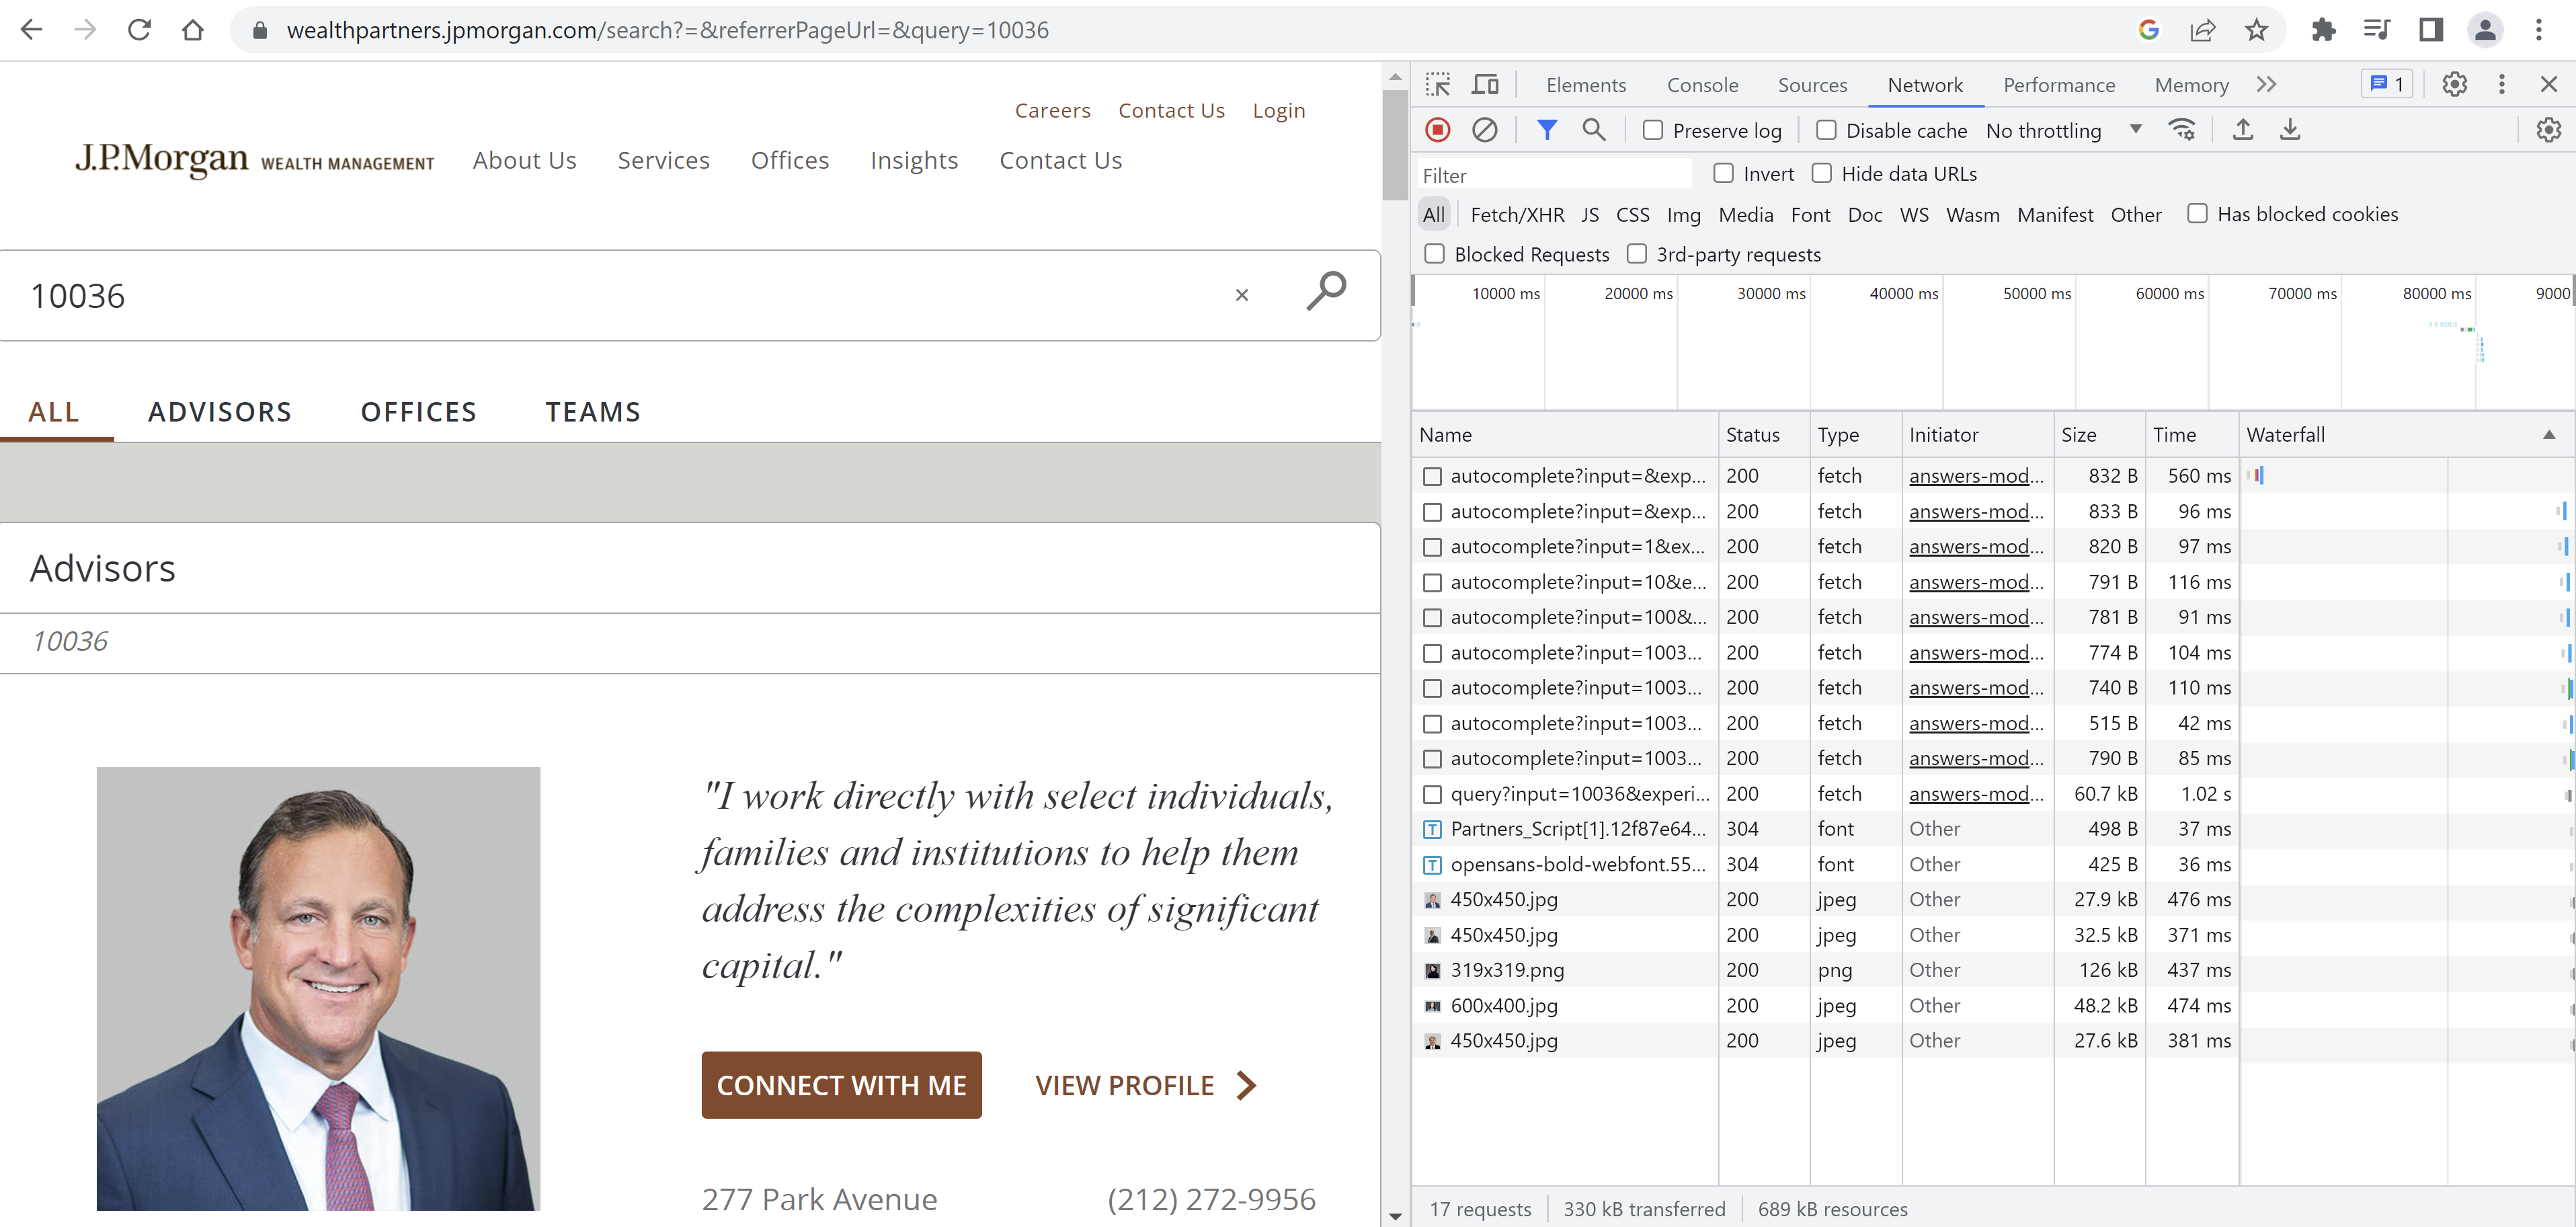

**Step 3: Find the item in the network tab that corresponds to the search**

In this case, it is easy to see it. It's the ```query?input=10036....```

If the tab contains a large number items, then you may want to use the 'filter' and look for things like your search terms, 'search', 'query' etc.

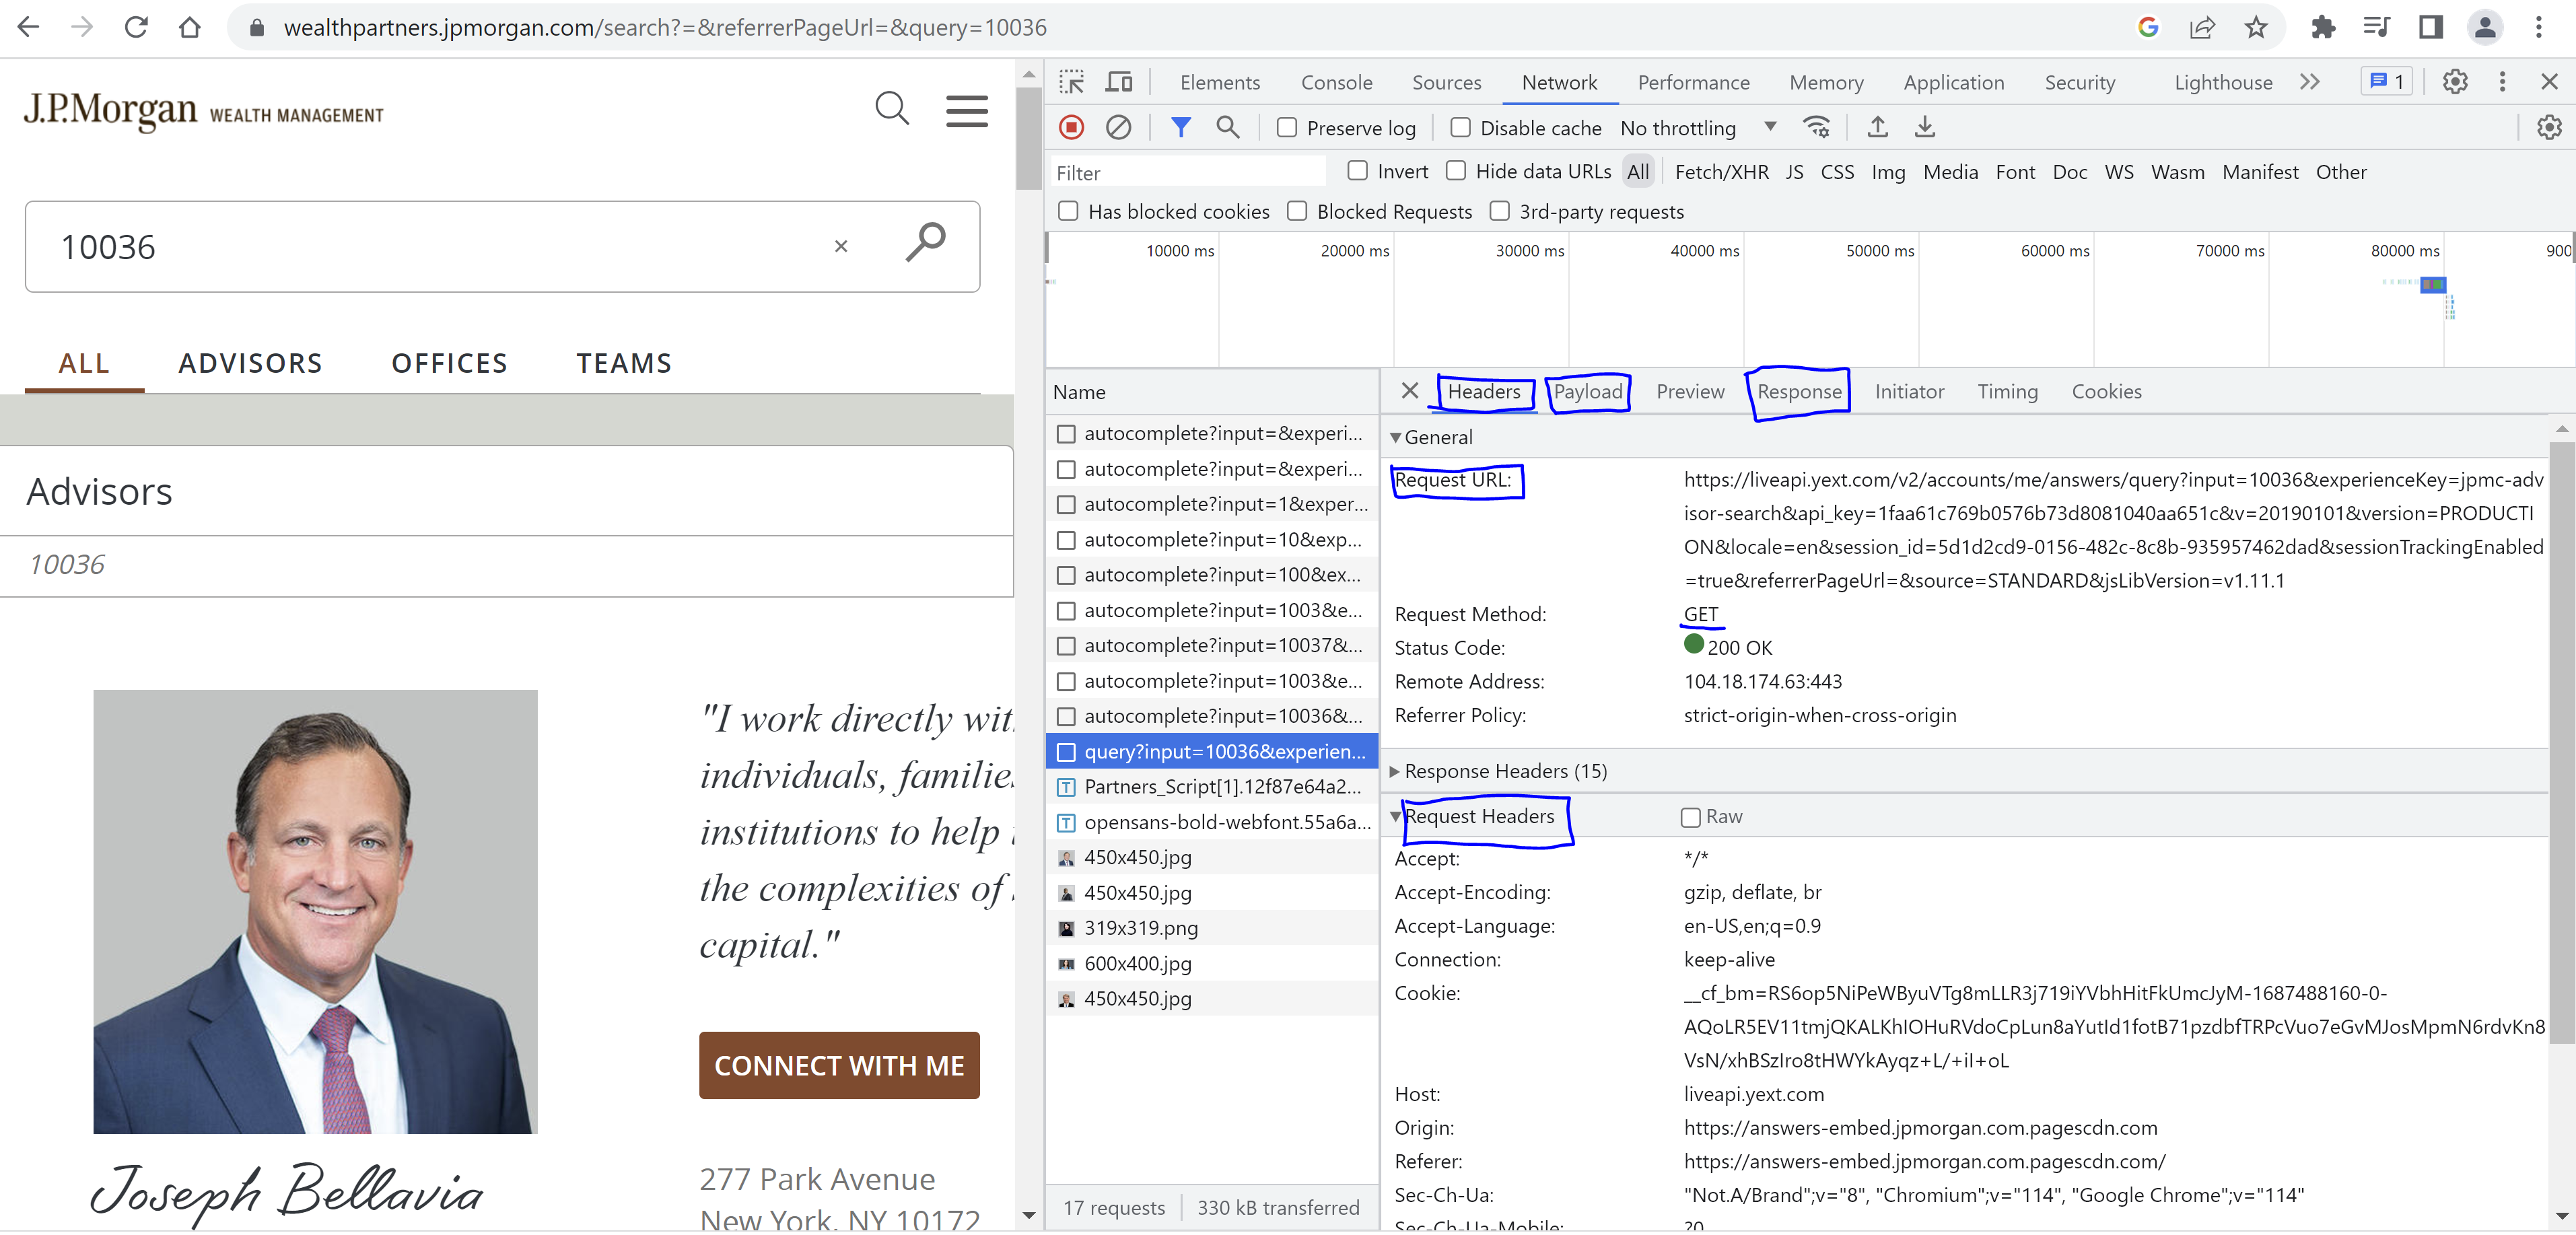

**Step 4: Take note of relevant components of the request**

Starting with the Headers sub-tab: The URL may be simple (just a path) or contain key information such as Search page number, randomized sorting number, and other potential dynamic components.

The Request method tells you if it is a GET or POST request

Request headers gives you the metadata. Most of these are static, but some times the Cookie doubles as an access key that can expire after a certain time (in which case you need to fetch a new cookie, either manually or using code). 

If the request method is a POST, then check the 'Payload' sub-tab for any 'data' that was sent to the search API. This may include search term and advanced search settings (in this example, it's irrelevant since it is a GET)

You may also want to check the Response sub-tab to understand what the format of the expected output is

**Step 5: Using the information from Step 4, we can put together our manual request**

To get the request headers in a Dictionary format, you can click the 'Raw' checkbox.

In this example, the search request contains an api_key. Potentially that may need to be refreshed over time too

In [65]:
# The cookie may need to be refreshed
cookie = '__cf_bm=RS6op5NiPeWByuVTg8mLLR3j719iYVbhHitFkUmcJyM-1687488160-0-AQoLR5EV11tmjQKALKhIOHuRVdoCpLun8aYutId1fotB71pzdbfTRPcVuo7eGvMJosMpmN6rdvKn8VsN/xhBSzIro8tHWYkAyqz+L/+iI+oL'

headers = {'Accept': '*/*',
          'Accept-Encoding': 'gzip, deflate, br',
          'Accept-Language': 'en-US,en;q=0.9',
          'Connection': 'keep-alive',
          'Cookie': cookie,
          'Host': 'liveapi.yext.com',
          'Origin': 'https://answers-embed.jpmorgan.com.pagescdn.com',
          'Referer': 'https://answers-embed.jpmorgan.com.pagescdn.com/',
          'Sec-Fetch-Dest': 'empty',
          'Sec-Fetch-Mode': 'cors',
          'Sec-Fetch-Site': 'cross-site',
          'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
          'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
          'sec-ch-ua-mobile': '?0',
          'sec-ch-ua-platform': '"Windows"'}

URL = 'https://liveapi.yext.com/v2/accounts/me/answers/query?input=10036&experienceKey=jpmc-advisor-search&api_key=1faa61c769b0576b73d8081040aa651c&v=20190101&version=PRODUCTION&locale=en&session_id=5d1d2cd9-0156-482c-8c8b-935957462dad&sessionTrackingEnabled=true&referrerPageUrl=&source=STANDARD&jsLibVersion=v1.11.1'

In [66]:
# Make the request
jpm_request = requests.get(URL, headers=headers)
jpm_request_content = jpm_request.content

In [68]:
# First 1000 characters
jpm_request_content[:1000]

b'{"meta":{"uuid":"0188e63a-2d64-f856-1787-f553a5df6064","errors":[]},"response":{"businessId":646613,"modules":[{"verticalConfigId":"advisors","resultsCount":243,"encodedState":"","results":[{"data":{"id":"joseph-bellavia","type":"financialProfessional","website":"https://wealthpartners.jpmorgan.com/new-york/the-armour-bellavia-stuhlman-group/joseph-bellavia","savedFilters":["134964","164405","183664","211951","213488","3220"],"address":{"line1":"277 Park Avenue","city":"New York","region":"NY","postalCode":"10172","countryCode":"US"},"description":"Enjoy a boutique experience and focused attention, delivered by a personal advisor team centered on you and your goals.","name":"Joseph Bellavia - J.P. Morgan Wealth Management","cityCoordinate":{"latitude":40.757929,"longitude":-73.985506},"c_aboutSectionHeading":"About Joseph Bellavia - J.P. Morgan Wealth Management","c_activeInAnswers":true,"c_jPMAQAPage":false,"c_activeOnPages":true,"c_advisorCategory":["Wealth Partner"],"c_advisorFirs

**This output is a binary formatted json, so we need to decode it**

In [71]:
data = json.loads(jpm_request_content.decode('utf-8'))
data

{'meta': {'uuid': '0188e63a-2d64-f856-1787-f553a5df6064', 'errors': []},
 'response': {'businessId': 646613,
  'modules': [{'verticalConfigId': 'advisors',
    'resultsCount': 243,
    'encodedState': '',
    'results': [{'data': {'id': 'joseph-bellavia',
       'type': 'financialProfessional',
       'website': 'https://wealthpartners.jpmorgan.com/new-york/the-armour-bellavia-stuhlman-group/joseph-bellavia',
       'savedFilters': ['134964',
        '164405',
        '183664',
        '211951',
        '213488',
        '3220'],
       'address': {'line1': '277 Park Avenue',
        'city': 'New York',
        'region': 'NY',
        'postalCode': '10172',
        'countryCode': 'US'},
       'description': 'Enjoy a boutique experience and focused attention, delivered by a personal advisor team centered on you and your goals.',
       'name': 'Joseph Bellavia - J.P. Morgan Wealth Management',
       'cityCoordinate': {'latitude': 40.757929, 'longitude': -73.985506},
       'c_aboutSec

**Step 6: Write the code necessary to extract the relevant information from this dictionary. And then create a loop to process many search results**

Here is the finished results

In [90]:
zipcodes = ['10036', '02442', '14738', '48637']

output_list = []

for zipcode in zipcodes:
    URL = f'https://liveapi.yext.com/v2/accounts/me/answers/query?input={zipcode}&experienceKey=jpmc-advisor-search&api_key=1faa61c769b0576b73d8081040aa651c&v=20190101&version=PRODUCTION&locale=en&session_id=5d1d2cd9-0156-482c-8c8b-935957462dad&sessionTrackingEnabled=true&referrerPageUrl=&source=STANDARD&jsLibVersion=v1.11.1'
    
    jpm_request = requests.get(URL, headers=headers)
    jpm_request_content = jpm_request.content
    data = json.loads(jpm_request_content.decode('utf-8'))

    # Parse data
    zipcode_results = []
    
    # If no results found, skip
    if len(data['response']['modules']) == 0:
        continue
    
    for item in data['response']['modules'][0]['results']:
        zipcode_results.append(pd.DataFrame({

            "First": item['data'].get("c_advisorFirstName"),
            "Middle": item['data'].get("c_advisorMiddleName"),
            "Last": item['data'].get("c_advisorLastName"),
            "Title": item['data'].get("c_advisorTitle"),
            "Team Name": item['data'].get('c_linkedTeam', {})[0].get('name'),
            "Postal Code": item['data'].get('address').get('postalCode'),

        }, index=[0]))
            
    output_list.append(pd.concat(zipcode_results))

In [91]:
# And we have the results!
pd.concat(output_list)

,First,Middle,Last,Title,Team Name,Postal Code
0,Joseph,None,Bellavia,Managing Director,The Armour Bellavia Stuhlman Group,10172
0,Ken,Kenneth,Farrell,Vice President,The Canell Group,10172
0,Colleen,None,O’Callaghan,Managing Director,The O’Callaghan Thomas Group,10172
0,Melinda,None,Cloobeck,Wealth Advisor,The Slattery Group,10604
0,Rick,None,Goodwyn,Managing Director,The Holland Goodwyn Group,10172
0,Hernan,None,Lautersztein,Executive Director,Hernan Lautersztein,10172
0,Neil,None,Canell,Managing Director,The Canell Group,10172
0,Robert,None,Kushel,Vice President,Gilman Private Wealth Management,10172
0,David,None,Kaplan,Executive Director,The LK Group,10604
0,Tad,None,Waldbauer,Managing Director,The Amato-Waldbauer Group,10172


**Note, for JPM searches, there is actually a limit in how many search results that the API returns, and we had to re-run the search for each ZIP multiple times if we maxed out the search results. That is not covered by the code above for simplicity**